In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **THIS IS NOT A PART OF THE ASSIGNMENT.**


IT ONLY RESTRUCTURES THE IMAGES INTO TRAIN, TEST, VALIDATE SUB-DIRECTORIES TO HELP EASY MODELLING.

YOU CAN MANUALLY CREATE THE TRAIN, TEST, VALIDATE SUB-DIRECTORIES BEFORE IMPORTING THEM.

YOU CAN VIEW THE DATASET USED HERE BY VISITING THE LINK ON THE WEBSITE


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from glob import glob
import pandas as pd

# --- CONFIGURATION (Adjust these paths and class names) ---

# !!! CRITICAL: Set this to the path where your 10 category folders are located in your Drive.
BASE_SOURCE_DIR = '/content/drive/MyDrive/IT Notes/SEM_7_NOTES/LP-4/objects'

# Set this to the path where you want the new structure to be built (e.g., in Colab's fast scratch space)
BASE_DEST_DIR = '/content/drive/MyDrive/colab datasets/LP4_datasets/objects'

# The names of your 10 category folders (must match exactly)
# NOTE: Replace these placeholders with the actual 10 category names.
CLASSES = [
    'panda', 'pigeon', 'pizza', 'pyramid',
    'revolver', 'rhino', 'rooster', 'scissors',
    'scorpion', 'stapler'
]

# Split Ratios
TRAIN_RATIO = 0.50 # 50% for training
VALID_RATIO = 0.25 # 25% for validation
TEST_RATIO = 0.25  # 25% for testing (Remaining 1 - 0.5 - 0.25 = 0.25)

# --- DIRECTORY CREATION ---

def create_dir_structure():
    """Creates the main train, valid, and test directories with class subfolders."""
    for split_name in ['train', 'valid', 'test']:
        for class_name in CLASSES:
            path = os.path.join(BASE_DEST_DIR, split_name, class_name)
            os.makedirs(path, exist_ok=True)
    print("New directory structure created successfully.")

# --- FILE SPLITTING AND MOVING ---

def split_and_move_files():
    """Splits files for each class into 50/25/25 and moves them."""

    # Calculate the remaining test_size after train split (50% + 25% = 75%)
    TEMP_RATIO = VALID_RATIO + TEST_RATIO  # Should be 0.50

    for class_name in CLASSES:
        source_path = os.path.join(BASE_SOURCE_DIR, class_name)

        # 1. Get all image file paths for the current class
        all_files = glob(os.path.join(source_path, '*'))

        if not all_files:
            print(f"WARNING: No files found in {source_path}. Skipping.")
            continue

        # --- First Split: Separate Training (50%) from Temporary (50%) ---
        train_files, temp_files = train_test_split(
            all_files,
            train_size=TRAIN_RATIO,
            random_state=42 # Use a fixed state for reproducibility
        )

        # --- Second Split: Divide Temporary (50%) into Validation (25%) and Test (25%) ---
        # The test_size here is calculated relative to the *temp_files* size (25% / 50% = 0.5)
        valid_files, test_files = train_test_split(
            temp_files,
            test_size=0.50, # 50% of the remaining 50% = 25% of the total
            random_state=42
        )

        print(f"\n{class_name}: Train={len(train_files)}, Valid={len(valid_files)}, Test={len(test_files)}")

        # --- Move Files to Final Destinations ---

        splits = {
            'train': train_files,
            'valid': valid_files,
            'test': test_files
        }

        for split_name, file_list in splits.items():
            dest_path = os.path.join(BASE_DEST_DIR, split_name, class_name)
            for file_path in file_list:
                # Use shutil.move to move the file from source to destination
                try:
                    shutil.move(file_path, dest_path)
                except Exception as e:
                    # Catch potential errors like file not found or permission issues
                    print(f"Error moving {file_path}: {e}")

# --- EXECUTION ---

# Create the required destination folders
create_dir_structure()

# Perform the splitting and moving
split_and_move_files()

print("\nDataset restructuring complete. New directory root is:", BASE_DEST_DIR)

New directory structure created successfully.

panda: Train=19, Valid=9, Test=10

pigeon: Train=22, Valid=11, Test=12

pizza: Train=26, Valid=13, Test=14

pyramid: Train=28, Valid=14, Test=15

revolver: Train=41, Valid=20, Test=21

rhino: Train=29, Valid=15, Test=15

rooster: Train=24, Valid=12, Test=13

scissors: Train=19, Valid=10, Test=10

scorpion: Train=42, Valid=21, Test=21

stapler: Train=22, Valid=11, Test=12

Dataset restructuring complete. New directory root is: /content/drive/MyDrive/colab datasets/LP4_datasets/objects


### **1. Setup and Data Loading**

In [ ]:
# Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os

In [ ]:
# Set Model Configuation

DATA_DIR = '/content/drive/MyDrive/colab datasets/LP4_datasets/objects'
NUM_CLASSES = 10
BATCH_SIZE = 32
NUM_EPOCHS = 5 # Simplified training length for quick learning
N_INPUTS = 4096 # Output size of VGG16's convolutional base (Corrected)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Declaring Dataset (images) Transformations

# Training dataset (Includes Augmentation)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)), # Resize + Crop
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation dataset (No Augmentation)
valid_transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Create Datasets

train_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transforms)
valid_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'valid'), transform=valid_transforms)

# Create Dataset Loaders

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

dataset_sizes = {'train': len(train_data), 'valid': len(valid_data)}

print("Data loaders created successfully.")

Data loaders created successfully.


### **2. Model Setup and Custom Classifier**

In [ ]:
# Load Pretrained Model: VGG16 with ImageNet weights
model = models.vgg16(weights='IMAGENET1K_V1')

# Freeze all the convolutional layer (initial layers) weights
for param in model.parameters():
    param.requires_grad = False

# Add our own custom classifier to replace the final layer of VGG16
# VGG16 has 7 layers, the final layer being indexed [6]

model.classifier[6] = nn.Sequential(
    # 1. Fully connected with ReLU: (25088 -> 256)
    nn.Linear(N_INPUTS, 256),
    nn.ReLU(),
    # 2. Dropout with 40% chance of dropping
    nn.Dropout(0.4),
    # 3. Fully connected with log softmax output: (256 -> 10 classes)
    nn.Linear(256, NUM_CLASSES),
    nn.LogSoftmax(dim=1)
)

model = model.to(device)

In [ ]:
# Initialize the loss and optimizer
criterion = nn.NLLLoss()

# Optimizer: ONLY pass the parameters of the custom classifier layer (model.classifier.parameters())
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

print("VGG16 frozen and custom classifier added.")

VGG16 frozen and custom classifier added.


### **3. Training and Evaluation Loop**

In [ ]:
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0
start_time = time.time()

print(f"\nStarting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):

    # Train and Validate in sequence for simplicity
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()  # Set model to training mode (Step u)
            loader = train_loader
        else:
            model.eval()   # Set model to evaluation mode
            loader = valid_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1) # (x) Predict the class

                # Backward pass and optimization (Only in training phase)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch statistics
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'Epoch {epoch+1}/{NUM_EPOCHS} | {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store history and track best accuracy
        if phase == 'train':
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc.item())
        else:
            history['val_loss'].append(epoch_loss)
            history['val_acc'].append(epoch_acc.item())
            if epoch_acc > best_acc:
                best_acc = epoch_acc # This implicitly handles best model tracking

print(f'\nTraining complete in {(time.time() - start_time) // 60:.0f}m {(time.time() - start_time) % 60:.0f}s')
print(f'Final Best Validation Accuracy: {best_acc:.4f}')


Starting training for 5 epochs...
Epoch 1/5 | train Loss: 1.3653 Acc: 0.5882
Epoch 1/5 | valid Loss: 0.3734 Acc: 0.9265
Epoch 2/5 | train Loss: 0.3406 Acc: 0.9265
Epoch 2/5 | valid Loss: 0.2203 Acc: 0.9485
Epoch 3/5 | train Loss: 0.1712 Acc: 0.9485
Epoch 3/5 | valid Loss: 0.2011 Acc: 0.9485
Epoch 4/5 | train Loss: 0.1303 Acc: 0.9596
Epoch 4/5 | valid Loss: 0.1822 Acc: 0.9559
Epoch 5/5 | train Loss: 0.0871 Acc: 0.9743
Epoch 5/5 | valid Loss: 0.1568 Acc: 0.9779

Training complete in 21m 40s
Final Best Validation Accuracy: 0.9779


### **4. Plot Performance**

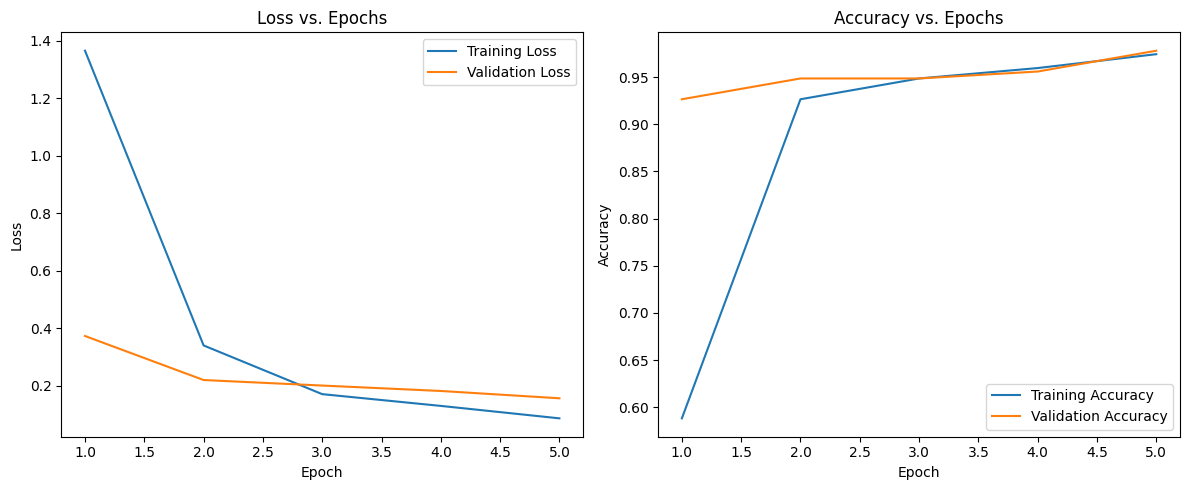

In [ ]:
plt.figure(figsize=(12, 5))
epochs_range = range(1, NUM_EPOCHS + 1)

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()